**Instituto Data Science Argentina**

Diplomatura en Ciencia de Datos con R y Python

Alumna: Verónica González

**Proyecto final: Text mining para el análisis de reseñas de productos**

**Problema:**
Una empresa dedicada a la venta online de suplementos nutricionales se propone comprender a fondo la opinión de sus clientes, especialmente aquellos que expresaron insatisfacción con sus compras. Este aspecto es crucial, ya que las críticas negativas pueden traducirse en pérdidas económicas significativas.

**Objetivo:**
El objetivo principal es utilizar la información extraída de las reseñas para mejorar la experiencia de compra de los clientes. La intención es evitar la pérdida de clientes existentes y, si es posible, recuperar a aquellos que se han perdido.

**Hipótesis:**
Se plantea la hipótesis de que la puntuación en estrellas de una reseña se puede predecir a partir del título de la misma. Además, se postula que identificar las palabras más frecuentes en las reseñas negativas proporcionará insights valiosos sobre los aspectos que requieren mejoras.

**Metodología:**
1. Para la obtención del dataset, se llevó a cabo un proceso de web scraping para recopilar un conjunto de datos que incluye todas las reseñas de la empresa publicadas en Trustpilot. Para esto, se emplearon las bibliotecas requests, BeautifulSoup, time y pandas.
2. EDA y preprocesamiento de los datos
3. Modelado y evaluación de algoritmos de machine learning
4. Evaluación de palabras más frecuentes por categoría de estrellas




In [1]:
# Bibliotecas utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Pre procesamiento
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix  
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
spacy.cli.download("es_core_news_sm")

## Balanceo de clases
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

## Bayes Ingenuo
from sklearn.naive_bayes import BernoulliNB as BernoulliNB_sk
from sklearn.naive_bayes import MultinomialNB as MultinomialNB_sk
from sklearn.naive_bayes import ComplementNB as ComplementNB_sk

## Redes Neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

## Regresión Logística
from sklearn.linear_model import LogisticRegression

## Evaluación de modelos e Informes 
from scipy.sparse import csr_matrix  # crea matriz dispersa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Nube de palabras y palabras + frecuentes
from wordcloud import WordCloud
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from collections import Counter

import warnings
warnings.filterwarnings("ignore")


✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [2]:
#Archivo con reseñas. Cargar archivo Reviews.xlsx
#from google.colab import files

#uploaded = files.upload()

In [3]:
#archivo con stop words en español. Cargar archivo spanish.txt
#from google.colab import files

#uploaded = files.upload()

In [4]:
datos = "C:/Users/veron/Documents/DCD 2022/Proyecto Final/Reviews.xlsx"
spanish = "C:/Users/veron/Documents/DCD 2022/Proyecto Final/spanish.txt"

In [5]:
df = pd.read_excel(datos)

# 1. Pre procesamiento y EDA


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14020 entries, 0 to 14019
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Nombre                 14020 non-null  object        
 1   Título                 14020 non-null  object        
 2   Reseña                 14020 non-null  object        
 3   Cantidad de Opiniones  14020 non-null  object        
 4   Estrellas              14020 non-null  object        
 5   País                   14020 non-null  object        
 6   Fecha Reseña           14020 non-null  datetime64[ns]
 7   Verificada             14020 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 876.4+ KB


In [7]:
df.isnull().mean()

Nombre                   0.0
Título                   0.0
Reseña                   0.0
Cantidad de Opiniones    0.0
Estrellas                0.0
País                     0.0
Fecha Reseña             0.0
Verificada               0.0
dtype: float64

In [8]:
df.head()

,Nombre,Título,Reseña,Cantidad de Opiniones,Estrellas,País,Fecha Reseña,Verificada
0,Jose Gallardo,Mejor comprar desde la página oficial,Mucho más informativa y ordenada que la página...,1 opinión,"<div class=""star-rating_starRating__4rrcf star...",ES,2023-10-12,No disponible
1,cliente,Como puede ser que sin previo aviso…,Como puede ser que sin previo aviso dejéis de ...,4 opiniones,"<div class=""star-rating_starRating__4rrcf star...",ES,2023-10-05,Verificada
2,Jose antonio García llorente,Los precios son los mejores y la…,"Los precios son los mejores y la calidad, pues...",2 opiniones,"<div class=""star-rating_starRating__4rrcf star...",ES,2023-10-14,No disponible
3,Mariló Andrade,Buena relación calidad precio y rápida entrega,Buenísima relación calidad precio y la entrega...,2 opiniones,"<div class=""star-rating_starRating__4rrcf star...",ES,2023-10-05,Verificada
4,javier,Llevo mucho tiempo comprando en esta…,"Llevo mucho tiempo comprando en esta empresa, ...",1 opinión,"<div class=""star-rating_starRating__4rrcf star...",ES,2023-10-12,Verificada


In [9]:
df['Fecha Reseña'].sort_values()
primera_fecha = df['Fecha Reseña'].min()
ultima_fecha = df['Fecha Reseña'].max()

print(f"Primera fecha: {primera_fecha}")
print(f"Última fecha: {ultima_fecha}")

Primera fecha: 2020-01-02 00:00:00
Última fecha: 2023-10-16 00:00:00


In [10]:
#Procesamiento de la variable estrellas (hay que extraer solo el número de estrellas)
df['Estrellas']= df['Estrellas'].astype(str)

In [11]:
df['Estrellas'].dtype

dtype('O')

In [12]:
def limpiar_estrellas(texto):
    texto = re.sub(r'src="https://cdn.trustpilot.net/brand-assets/4.1.0/stars/stars-5.svg"/></div>', '', texto)
    texto = re.sub(r'src="https://cdn.trustpilot.net/brand-assets/4.1.0/stars/stars-4.svg"/></div>', '', texto)
    texto = re.sub(r'src="https://cdn.trustpilot.net/brand-assets/4.1.0/stars/stars-3.svg"/></div>', '', texto)
    texto = re.sub(r'src="https://cdn.trustpilot.net/brand-assets/4.1.0/stars/stars-2.svg"/></div>', '', texto)
    texto = re.sub(r'src="https://cdn.trustpilot.net/brand-assets/4.1.0/stars/stars-1.svg"/></div>', '', texto)
    texto = re.sub(r'<div class="star-rating_starRating__4rrcf star-rating_medium__iN6Ty">', '', texto)
    texto = re.sub(r'<img alt="Valorada con', '', texto)
    texto = re.sub(r'estrellas sobre 5"', '', texto)
    return texto

df['Estrellas'] = df['Estrellas'].apply(limpiar_estrellas)



In [13]:
df.head()

,Nombre,Título,Reseña,Cantidad de Opiniones,Estrellas,País,Fecha Reseña,Verificada
0,Jose Gallardo,Mejor comprar desde la página oficial,Mucho más informativa y ordenada que la página...,1 opinión,5,ES,2023-10-12,No disponible
1,cliente,Como puede ser que sin previo aviso…,Como puede ser que sin previo aviso dejéis de ...,4 opiniones,1,ES,2023-10-05,Verificada
2,Jose antonio García llorente,Los precios son los mejores y la…,"Los precios son los mejores y la calidad, pues...",2 opiniones,5,ES,2023-10-14,No disponible
3,Mariló Andrade,Buena relación calidad precio y rápida entrega,Buenísima relación calidad precio y la entrega...,2 opiniones,5,ES,2023-10-05,Verificada
4,javier,Llevo mucho tiempo comprando en esta…,"Llevo mucho tiempo comprando en esta empresa, ...",1 opinión,3,ES,2023-10-12,Verificada


In [14]:
df['País'].value_counts()
 

ES    13796
GB       39
US       21
IT       21
FR       18
PT       15
NL       14
DE       12
CH       11
IE       10
BE        7
AD        6
AR        4
DK        3
ID        3
MA        3
NO        2
VE        2
RO        2
MD        2
BR        2
TR        2
CU        1
TW        1
BO        1
CR        1
CO        1
AT        1
IN        1
PH        1
DO        1
LB        1
PK        1
AF        1
MU        1
IM        1
IL        1
PE        1
SN        1
SE        1
TH        1
UY        1
SI        1
IQ        1
FI        1
BG        1
CA        1
Name: País, dtype: int64

In [15]:
print((df['País'].value_counts() / len(df)) * 100)



ES    98.402282
GB     0.278174
US     0.149786
IT     0.149786
FR     0.128388
PT     0.106990
NL     0.099857
DE     0.085592
CH     0.078459
IE     0.071327
BE     0.049929
AD     0.042796
AR     0.028531
DK     0.021398
ID     0.021398
MA     0.021398
NO     0.014265
VE     0.014265
RO     0.014265
MD     0.014265
BR     0.014265
TR     0.014265
CU     0.007133
TW     0.007133
BO     0.007133
CR     0.007133
CO     0.007133
AT     0.007133
IN     0.007133
PH     0.007133
DO     0.007133
LB     0.007133
PK     0.007133
AF     0.007133
MU     0.007133
IM     0.007133
IL     0.007133
PE     0.007133
SN     0.007133
SE     0.007133
TH     0.007133
UY     0.007133
SI     0.007133
IQ     0.007133
FI     0.007133
BG     0.007133
CA     0.007133
Name: País, dtype: float64


In [16]:
print(df['Verificada'].value_counts())
print((df['Verificada'].value_counts() / len(df)) * 100)

Verificada        7559
No disponible     6248
Redirigida         141
Por invitación      62
Fusionado           10
Name: Verificada, dtype: int64
Verificada        53.915835
No disponible     44.564907
Redirigida         1.005706
Por invitación     0.442225
Fusionado          0.071327
Name: Verificada, dtype: float64


Si bien el datset no tiene datos faltantes, algunas reseñas aparecen como "No disponible", debido a que algunos usuarios completan el espacio correspondiente al titulo y no la reseña. También sucede que si el usuario no escribe el título, este se genera automáticamente con las primeras palabras de la reseña. Dado que el dataset no es muy grande y no para no perder muestras (2544), se decide trabajar con el título que está completo en todos los casos.



In [76]:
df['Reseña'].value_counts()

No disponible                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          2544
Todo perfecto                                                                                                                                                                                                                                                               

In [19]:
df['Estrellas'].value_counts()

 5      11684
 4       1076
 1        640
 3        373
 2        247
Name: Estrellas, dtype: int64

##### La categoría de 5 estrellas representa el 83% de la muestra. Este desbalanceo se tendrá en cuenta más adelante, en el entrenamiento de los modelos.
##### Se decide trabajar solo con las variables Estrellas y Título.

 5      0.833381
 4      0.076748
 1      0.045649
 3      0.026605
 2      0.017618
Name: Estrellas, dtype: float64


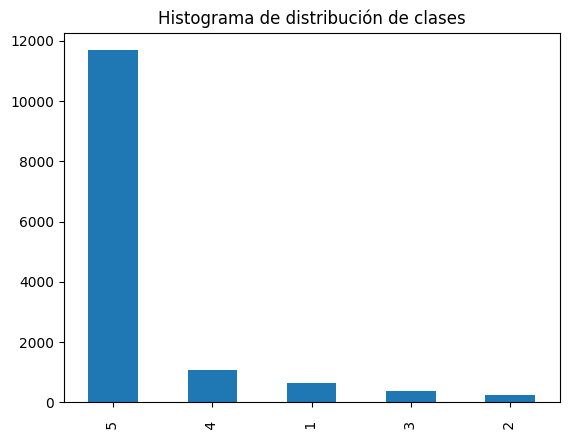

In [20]:
df['Estrellas'].value_counts().plot(kind='bar', title='Histograma de distribución de clases')
print(df['Estrellas'].value_counts() / len(df))

In [21]:
# se crea un función para limpiar y lemmatizar el texto (eliminar puntos y signos)
nlp = spacy.load("es_core_news_sm")

def lemmatizar_y_limpiar(texto):
    texto = texto.lower()
    doc = nlp(texto)

    # Inicializar una lista para almacenar los lemas de las palabras
    lemas = []

    # Iterar a través de los tokens del documento
    for token in doc:
        # Lematizar y convertir a minúsculas
        lema = token.lemma_.lower()

        # Si el token no es un punto o signo de puntuación, agregar el lema
        if not token.is_punct and not lema.isspace():
            lemas.append(lema)

    # Unir los lemas en una cadena de texto
    texto_lemmatizado = " ".join(lemas)

    return texto_lemmatizado




In [22]:
Y, X = df['Estrellas'], df['Título']
X = X.apply(lemmatizar_y_limpiar)

le = LabelEncoder()
y = le.fit_transform(Y)
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)
print(type(X_train_text))

# Tamaño de los conjuntos de entrenamiento y prueba
print(f"Tamaño del conjunto de entrenamiento (X): {X_train_text.shape}")
print(f"Tamaño del conjunto de prueba (X): {X_test_text.shape}")
print(f"Tamaño del conjunto de entrenimiento (y): {y_train.shape}")
print(f"Tamaño del conjunto de prueba (y): {y_test.shape}")

# con stratify= y le pedimos que respete la misma distribucion de clases.
# obtengo una serie de Pandas

<class 'pandas.core.series.Series'>
Tamaño del conjunto de entrenamiento (X): (10515,)
Tamaño del conjunto de prueba (X): (3505,)
Tamaño del conjunto de entrenimiento (y): (10515,)
Tamaño del conjunto de prueba (y): (3505,)


In [23]:
with open(spanish, 'r', encoding='utf-8') as archivo:
    # Lee el contenido del archivo y divide las palabras en una lista
    stop_spanish = archivo.read().split()

In [24]:
print(stop_spanish)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosostros', 'vosostras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 

### Modelos

# Bayes Ingenuo

### Se utilizan la variante Multinomial (características discretas),  Complement (porque las clases están desbalanceadas) y también Bernoulli (para considerar solo la ocurrencia o no de la palabra). No se utiliza Gaussian porque no hay distribución normal ni tampoco se utiliza categorical. Dado que las clases están desbalanceadas, se probarán los algoritmos utilizando los datos originales en primer lugar, luego se asignarán pesos a las clases y por último se utilizará la técnica de sobremuestreo SMOTE y RandomOverSampling. No se probará submuestreo porque el dataset quedaría muy pequeño.

## CountVectorizer + Bernoulli  

En la variante Bernouli se crea un vector binarizado y se utiliza CountVectorizer porque interesa saber si la palabra está presente o no (y no con qué frecuencia está presente).


In [25]:
vec1 = CountVectorizer(stop_words=stop_spanish, binary=True, ngram_range=(1,3))
x_train1 = vec1.fit_transform(X_train_text)
x_test1 = vec1.transform(X_test_text)
bnb1 = BernoulliNB_sk()
bnb1.fit(x_train1, y_train)
print(f'Score para BN Bernoulli {bnb1.score(x_test1, y_test)}')

# Imprimir esparcidad del train y test
print(x_train1.nnz / (x_train1.shape[0] * x_train1.shape[1])*100)
print(x_test1.nnz / (x_test1.shape[0] * x_test1.shape[1])*100)
print(type(x_train1))

# Informe de clasificación
y_pred = bnb1.predict(x_test1)
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Bernoulli 0.8336661911554921
0.03386299231211124
0.025985448808336014
<class 'scipy.sparse._csr.csr_matrix'>
              precision    recall  f1-score   support

           1       1.00      0.01      0.01       160
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        93
           4       0.00      0.00      0.00       269
           5       0.83      1.00      0.91      2921

    accuracy                           0.83      3505
   macro avg       0.37      0.20      0.18      3505
weighted avg       0.74      0.83      0.76      3505

Reales     0  3     4   All
Predichos                  
0          1  1   158   160
1          0  1    61    62
2          0  0    93    93
3          0  0   269   269
4          0  0  2921  2921
All        1  2  3502  3505


In [26]:
# Definir los pesos de clase
class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 0.17
}

# Calcular las probabilidades a priori a partir de los pesos de clase
class_priors = [class_weights[i] / sum(class_weights.values()) for i in range(len(class_weights))]

# Crear el clasificador Bernoulli Naive Bayes con pesos de clase
bnb2 = BernoulliNB_sk(class_prior=class_priors, fit_prior=False)

# Entrenar el modelo
bnb2.fit(x_train1, y_train)

# Evaluar el modelo en el conjunto de prueba
print(f'Score para BN Bernoulli con pesos {bnb2.score(x_test1, y_test)}')

# Informe de clasificación
y_pred = bnb2.predict(x_test1)
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)


Score para BN Bernoulli con pesos 0.8336661911554921
              precision    recall  f1-score   support

           1       1.00      0.01      0.01       160
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        93
           4       0.00      0.00      0.00       269
           5       0.83      1.00      0.91      2921

    accuracy                           0.83      3505
   macro avg       0.37      0.20      0.18      3505
weighted avg       0.74      0.83      0.76      3505

Reales     0  3     4   All
Predichos                  
0          1  1   158   160
1          0  1    61    62
2          0  0    93    93
3          0  0   269   269
4          0  0  2921  2921
All        1  2  3502  3505


In [27]:
# Sobremuestreo con SMOTE
# Aplica SMOTE al conjunto de entrenamiento (con auto, all y not majority da igual)
smote = SMOTE(sampling_strategy='not majority', random_state=1)
x_train_resampled_cv, y_train_resampled_cv = smote.fit_resample(x_train1, y_train)

# Entrenamiento del modelo en el conjunto de entrenamiento sobremuestreado
bnb1.fit(x_train_resampled_cv, y_train_resampled_cv)

# Evalúa el modelo en el conjunto de prueba original
print(f'Score para BN Bernoulli con oversampling SMOTE {bnb1.score(x_test1, y_test)}')

# Informe de clasificación
y_pred = bnb1.predict(x_test1)
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Bernoulli con oversampling SMOTE 0.503851640513552
              precision    recall  f1-score   support

           1       0.29      0.59      0.39       160
           2       0.04      0.15      0.07        62
           3       0.09      0.23      0.13        93
           4       0.08      0.32      0.13       269
           5       0.91      0.53      0.67      2921

    accuracy                           0.50      3505
   macro avg       0.29      0.36      0.28      3505
weighted avg       0.79      0.50      0.59      3505

Reales       0    1    2     3     4   All
Predichos                                 
0           95   27   18     3    17   160
1           27    9   15     3     8    62
2           27    8   21    19    18    93
3           35   19   26    87   102   269
4          140  150  142   935  1554  2921
All        324  213  222  1047  1699  3505


In [28]:
# Sobremuestreo con RandomOverSampler
# Aplica RandomOverSampler al conjunto de entrenamiento
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=1)
x_train_resampled2_cv, y_train_resampled2_cv = oversampler.fit_resample(x_train1, y_train)

# Entrenamiento del modelo en el conjunto de entrenamiento sobremuestreado
bnb1.fit(x_train_resampled2_cv, y_train_resampled2_cv)

# Evalúa el modelo en el conjunto de prueba original
print(f'Score para BN Bernoulli con oversampling RandomOverSampler {bnb1.score(x_test1, y_test)}')

# Informe de clasificación
y_pred = bnb1.predict(x_test1)
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Bernoulli con oversampling RandomOverSampler 0.7169757489300999
              precision    recall  f1-score   support

           1       0.36      0.37      0.36       160
           2       0.15      0.26      0.19        62
           3       0.12      0.18      0.14        93
           4       0.12      0.22      0.15       269
           5       0.92      0.81      0.86      2921

    accuracy                           0.72      3505
   macro avg       0.33      0.37      0.34      3505
weighted avg       0.79      0.72      0.75      3505

Reales       0    1    2    3     4   All
Predichos                                
0           59   35   22   10    34   160
1           14   16   20    5     7    62
2           20   15   17   21    20    93
3           21   11   23   60   154   269
4           51   30   62  417  2361  2921
All        165  107  144  513  2576  3505


## TF-IDF + Multinomial  

Se transforma el texto con un vectorizador TF-IDF y luego se corre la variante multinomial.

In [29]:
vec2 = TfidfVectorizer(stop_words=stop_spanish, ngram_range=(1,3))
x_train2 = vec2.fit_transform(X_train_text)
x_test2 = vec2.transform(X_test_text)
print('type x_train', type(x_train2))
mnb1 = MultinomialNB_sk()
mnb1.fit(x_train2, y_train)
print(f'Score para BN Multinomial {mnb1.score(x_test2, y_test)}')

# Informe de clasificación
y_pred = mnb1.predict(x_test2)
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



type x_train <class 'scipy.sparse._csr.csr_matrix'>
Score para BN Multinomial 0.8333808844507846
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       160
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        93
           4       0.00      0.00      0.00       269
           5       0.83      1.00      0.91      2921

    accuracy                           0.83      3505
   macro avg       0.17      0.20      0.18      3505
weighted avg       0.69      0.83      0.76      3505

Reales        4   All
Predichos            
0           160   160
1            62    62
2            93    93
3           269   269
4          2921  2921
All        3505  3505


In [30]:
# Utilizando pesos de clases

# Crear el clasificador Multinomial Naive Bayes con pesos de clase
mnb2 = MultinomialNB_sk(class_prior=class_priors, fit_prior=False)

# Entrenar el modelo
mnb2.fit(x_train2, y_train)

# Evaluar el modelo en el conjunto de prueba
print(f'Score para BN Multinomial con pesos {mnb2.score(x_test2, y_test)}')

# Informe de clasificación
y_pred = mnb2.predict(x_test2)
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Multinomial con pesos 0.6022824536376605
              precision    recall  f1-score   support

           1       0.29      0.66      0.41       160
           2       0.06      0.06      0.06        62
           3       0.16      0.12      0.13        93
           4       0.11      0.40      0.17       269
           5       0.94      0.64      0.76      2921

    accuracy                           0.60      3505
   macro avg       0.31      0.38      0.31      3505
weighted avg       0.81      0.60      0.67      3505

Reales       0   1   2    3     4   All
Predichos                              
0          106  10  15   24     5   160
1           33   4  13    9     3    62
2           25   5  11   43     9    93
3           38   5   5  108   113   269
4          158  45  26  810  1882  2921
All        360  69  70  994  2012  3505


In [31]:
# Sobremuestreo con SMOTE

# Aplica SMOTE al conjunto de entrenamiento (con auto, all y not majority da igual)
smote = SMOTE(sampling_strategy='not majority', random_state=1)
x_train_resampled_tf, y_train_resampled_tf = smote.fit_resample(x_train2, y_train)

# Entrenamiento del modelo en el conjunto de entrenamiento sobremuestreado
mnb1.fit(x_train_resampled_tf, y_train_resampled_tf)

# Evalúa el modelo en el conjunto de prueba original
print(f'Score para BN Multinomial con SMOTE {mnb1.score(x_test2, y_test)}')

# Informe de clasificación
y_pred = mnb1.predict(x_test2)
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Multinomial con SMOTE 0.6379457917261055
              precision    recall  f1-score   support

           1       0.30      0.50      0.37       160
           2       0.10      0.21      0.13        62
           3       0.10      0.24      0.14        93
           4       0.11      0.28      0.16       269
           5       0.93      0.70      0.80      2921

    accuracy                           0.64      3505
   macro avg       0.31      0.39      0.32      3505
weighted avg       0.80      0.64      0.70      3505

Reales       0    1    2    3     4   All
Predichos                                
0           80   30   29   10    11   160
1           22   13   18    4     5    62
2           23   17   22   18    13    93
3           30   15   32   76   116   269
4          114   58  117  587  2045  2921
All        269  133  218  695  2190  3505


In [32]:
# Sobremuestreo con RandomOverSampler
# Aplica RandomOverSampler al conjunto de entrenamiento
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=1)
x_train_resampled2_tf, y_train_resampled2_tf = oversampler.fit_resample(x_train2, y_train)

# Entrenamiento del modelo en el conjunto de entrenamiento sobremuestreado
mnb1.fit(x_train_resampled2_tf, y_train_resampled2_tf)

# Evalúa el modelo en el conjunto de prueba original
print(f'Score para BN Multinomial con oversampling RandomOverSampler {mnb1.score(x_test2, y_test)}')

# Informe de clasificación
y_pred = mnb1.predict(x_test2)
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Multinomial con oversampling RandomOverSampler 0.6559201141226819
              precision    recall  f1-score   support

           1       0.30      0.51      0.38       160
           2       0.09      0.18      0.12        62
           3       0.12      0.27      0.16        93
           4       0.11      0.26      0.16       269
           5       0.94      0.72      0.82      2921

    accuracy                           0.66      3505
   macro avg       0.31      0.39      0.33      3505
weighted avg       0.81      0.66      0.72      3505

Reales       0    1    2    3     4   All
Predichos                                
0           82   28   30   11     9   160
1           21   11   22    4     4    62
2           26   15   25   18     9    93
3           31   13   31   71   123   269
4          115   51  109  536  2110  2921
All        275  118  217  640  2255  3505


## CountVectorizer + Complement
La variante Complement se utiliza con CountVectorizer para intentar obtener mejores resultados trabajando con clases desbalanceadas.

In [33]:
vec3 = CountVectorizer(stop_words=stop_spanish, ngram_range=(1,3))
x_train3 = vec3.fit_transform(X_train_text)
x_test3 = vec3.transform(X_test_text)
cnb1 = ComplementNB_sk()
cnb1.fit(x_train3, y_train)
print(f'Score para BN Complement {cnb1.score(x_test3, y_test)}')

# Informe de clasificación
y_pred = cnb1.predict(x_test3)
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Complement 0.8171184022824537
              precision    recall  f1-score   support

           1       0.34      0.57      0.42       160
           2       0.14      0.10      0.11        62
           3       0.14      0.10      0.12        93
           4       0.16      0.05      0.08       269
           5       0.90      0.94      0.92      2921

    accuracy                           0.82      3505
   macro avg       0.34      0.35      0.33      3505
weighted avg       0.79      0.82      0.80      3505

Reales       0   1   2   3     4   All
Predichos                             
0           91  11  13   7    38   160
1           32   6  12   3     9    62
2           30   6   9  11    37    93
3           30   4   7  14   214   269
4           86  17  22  52  2744  2921
All        269  44  63  87  3042  3505


In [34]:
# Crear el clasificador Complement Naive Bayes con pesos de clase
cnb2 = ComplementNB_sk(class_prior=class_priors, fit_prior=False)

# Entrenar el modelo
cnb2.fit(x_train3, y_train)

# Evaluar el modelo en el conjunto de prueba
print(f'Score para BN Complement con pesos de clase {cnb2.score(x_test3, y_test)}')

# Informe de clasificación
y_pred = cnb2.predict(x_test3)
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Complement con pesos de clase 0.8171184022824537
              precision    recall  f1-score   support

           1       0.34      0.57      0.42       160
           2       0.14      0.10      0.11        62
           3       0.14      0.10      0.12        93
           4       0.16      0.05      0.08       269
           5       0.90      0.94      0.92      2921

    accuracy                           0.82      3505
   macro avg       0.34      0.35      0.33      3505
weighted avg       0.79      0.82      0.80      3505

Reales       0   1   2   3     4   All
Predichos                             
0           91  11  13   7    38   160
1           32   6  12   3     9    62
2           30   6   9  11    37    93
3           30   4   7  14   214   269
4           86  17  22  52  2744  2921
All        269  44  63  87  3042  3505


In [35]:
# Aplica SMOTE al conjunto de entrenamiento (con auto, all y not majority da igual)
smote = SMOTE(sampling_strategy='not majority', random_state=1)
x_train_resampled_cv, y_train_resampled_cv = smote.fit_resample(x_train3, y_train)

# Entrenamiento del modelo en el conjunto de entrenamiento sobremuestreado
cnb1.fit(x_train_resampled_cv, y_train_resampled_cv)

# Evalúa el modelo en el conjunto de prueba original
print(f'Score para BN Complement SMOTE {cnb1.score(x_test3, y_test)}')

# Informe de clasificación
y_pred = cnb1.predict(x_test3)
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Complement SMOTE 0.7007132667617689
              precision    recall  f1-score   support

           1       0.29      0.59      0.39       160
           2       0.19      0.18      0.18        62
           3       0.19      0.17      0.18        93
           4       0.12      0.24      0.16       269
           5       0.92      0.78      0.84      2921

    accuracy                           0.70      3505
   macro avg       0.34      0.39      0.35      3505
weighted avg       0.79      0.70      0.74      3505

Reales       0   1   2    3     4   All
Predichos                              
0           94  16  17    6    27   160
1           28  11  10    4     9    62
2           29   7  16   20    21    93
3           41   5   9   65   149   269
4          130  20  33  468  2270  2921
All        322  59  85  563  2476  3505


In [36]:
# Entrenamiento del modelo en el conjunto de entrenamiento sobremuestreado
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=1)
x_train_resampled2_cv, y_train_resampled2_cv = oversampler.fit_resample(x_train3, y_train)


# Entrenamiento del modelo en el conjunto de entrenamiento sobremuestreado
cnb1.fit(x_train_resampled2_cv, y_train_resampled2_cv)

# Evalúa el modelo en el conjunto de prueba original
print(f'Score para BN Complement RandomOverSampler {cnb1.score(x_test3, y_test)}')

# Informe de clasificación
y_pred = cnb1.predict(x_test3)
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Complement RandomOverSampler 0.6459343794579172
              precision    recall  f1-score   support

           1       0.29      0.51      0.37       160
           2       0.12      0.24      0.16        62
           3       0.09      0.20      0.13        93
           4       0.10      0.25      0.15       269
           5       0.93      0.71      0.81      2921

    accuracy                           0.65      3505
   macro avg       0.31      0.38      0.32      3505
weighted avg       0.80      0.65      0.71      3505

Reales       0    1    2    3     4   All
Predichos                                
0           82   26   23   11    18   160
1           19   15   18    4     6    62
2           27   13   19   17    17    93
3           34   15   27   68   125   269
4          117   55  114  555  2080  2921
All        279  124  201  655  2246  3505


## Redes Neuronales
#### Se contruyen redes neuronales considerando sobremuestrear a las clases minoritarias y luego utilizando distintos pesos para cada clase

In [37]:
vec = TfidfVectorizer(stop_words=stop_spanish, ngram_range=(1,3))
x_train = vec.fit_transform(X_train_text)
x_test = vec.transform(X_test_text)

In [38]:
## Se utiliza early stopping para intentar evitar el sobreajuste

# Convertir matrices dispersas en matrices densas 
x_train = x_train.toarray()
x_test = x_test.toarray()

# Realiza el sobremuestreo solo en el conjunto de entrenamiento
oversampler = RandomOverSampler(sampling_strategy='not minority', random_state=1)
X_train_resampled, y_train_resampled = oversampler.fit_resample(x_train, y_train)

# se especifica una semilla para la inicializacion de los pesos de la red (puede tener un componente aleatorio)
np.random.seed(1)
tf.random.set_seed(1)


# Define el modelo de la red neuronal
model = keras.Sequential([
    keras.layers.Input(shape=(X_train_resampled.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

# Compila el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrena el modelo con el conjunto de entrenamiento sobremuestreado y EarlyStopping
model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evalúa el modelo en el conjunto de prueba original
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_acc}')

# Informe de clasificación
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Epoch 1/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7629 - loss: 0.6913 - val_accuracy: 0.4432 - val_loss: 1.1748
Epoch 2/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9411 - loss: 0.1651 - val_accuracy: 0.6556 - val_loss: 0.7913
Epoch 3/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9548 - loss: 0.1230 - val_accuracy: 0.6748 - val_loss: 0.7229
Epoch 4/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9590 - loss: 0.1090 - val_accuracy: 0.6781 - val_loss: 0.6918
Epoch 5/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9595 - loss: 0.1046 - val_accuracy: 0.6758 - val_loss: 0.6785
Epoch 6/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.9593 - loss: 0.1019 - val_accuracy: 0.6731 - val_loss: 0.6609
Epoch 7/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9598 - loss: 0.0998 - val_accuracy: 0.6700 - val_loss: 0.6562
Epoch 8/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9603 - loss: 0

In [39]:
# Realizar el sobremuestreo solo en el conjunto de entrenamiento utilizando SMOTE
smote = SMOTE(sampling_strategy='not minority', random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

np.random.seed(1)
tf.random.set_seed(1)

# Define el modelo de la red neuronal
model = keras.Sequential([
    keras.layers.Input(shape=(X_train_resampled.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

# Compila el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrena el modelo con el conjunto de entrenamiento sobremuestreado y EarlyStopping
model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evalúa el modelo en el conjunto de prueba original
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_acc}')

# Informe de clasificación
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Epoch 1/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.8271 - loss: 0.6235 - val_accuracy: 0.3614 - val_loss: 1.1441
Epoch 2/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9423 - loss: 0.1541 - val_accuracy: 0.5986 - val_loss: 0.7729
Epoch 3/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9574 - loss: 0.1114 - val_accuracy: 0.6635 - val_loss: 0.6575
Epoch 4/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9633 - loss: 0.0954 - val_accuracy: 0.6869 - val_loss: 0.6038
Epoch 5/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9653 - loss: 0.0898 - val_accuracy: 0.7026 - val_loss: 0.5610
Epoch 6/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9669 - loss: 0.0862 - val_accuracy: 0.6998 - val_loss: 0.5445
Epoch 7/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9678 - loss: 0.0832 - val_accuracy: 0.7080 - val_loss: 0.5187
Epoch 8/100
881/881 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.9682 - loss: 0

In [40]:
# Asignar pesos a las clases minoritarias
class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 0.17
}

# Convertir las matrices dispersas a arrays NumPy densos
#x_train = x_train.toarray()
# = x_test.toarray()

np.random.seed(1)
tf.random.set_seed(1)


# Define el modelo de la red neuronal
model = keras.Sequential([
    keras.layers.Input(shape=(x_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

# Compila el modelo con pesos de clase

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrena el modelo
model.fit(x_train, y_train, epochs=200, batch_size=32, sample_weight=np.array([class_weights[c] for c in y_train]), validation_split=0.2, callbacks=[early_stopping] )

# Evalúa el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_acc}')

# Informe de clasificación
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Epoch 1/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.7731 - loss: 0.4189 - val_accuracy: 0.6952 - val_loss: 0.3343
Epoch 2/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8243 - loss: 0.2801 - val_accuracy: 0.6505 - val_loss: 0.3484
Epoch 3/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8749 - loss: 0.1651 - val_accuracy: 0.6576 - val_loss: 0.4090
Epoch 4/200
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9159 - loss: 0.0990 - val_accuracy: 0.6681 - val_loss: 0.4638
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7434 - loss: 0.7578
Precisión en el conjunto de prueba: 0.7332382202148438
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           1       0.30      0.88      0.45       160
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        93
           4       0.12      0.21      0.15       269
           5       0.93      0.81     

# Regresión Logística

In [41]:
# Define el modelo de regresión logística
logreg = LogisticRegression(max_iter=200)

# Entrena el modelo
logreg.fit(x_train, y_train)

# Evalúa el modelo en el conjunto de prueba
test_acc = logreg.score(x_test, y_test)
print(f'Precisión en el conjunto de prueba (con pesos de clases): {test_acc}')

# Informe de clasificación
y_pred = logreg.predict(x_test)
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)




Precisión en el conjunto de prueba (con pesos de clases): 0.8427960057061341
              precision    recall  f1-score   support

           1       0.53      0.21      0.30       160
           2       0.00      0.00      0.00        62
           3       0.31      0.04      0.08        93
           4       0.18      0.01      0.01       269
           5       0.85      1.00      0.92      2921

    accuracy                           0.84      3505
   macro avg       0.37      0.25      0.26      3505
weighted avg       0.76      0.84      0.78      3505

Reales      0   2   3     4   All
Predichos                        
0          34   1   0   125   160
1          11   6   1    44    62
2           5   4   7    77    93
3           8   2   2   257   269
4           6   0   1  2914  2921
All        64  13  11  3417  3505


In [42]:
# Utilizando pesos de clases
# Define el modelo de regresión logística
logreg2 = LogisticRegression(class_weight=class_weights, max_iter=200)

# Entrena el modelo
logreg2.fit(x_train, y_train)

# Evalúa el modelo en el conjunto de prueba
test_acc = logreg2.score(x_test, y_test)
print(f'Precisión en el conjunto de prueba (con pesos de clases): {test_acc}')

# Informe de clasificación
y_pred = logreg2.predict(x_test)
etiquetas = ['1', '2', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Precisión en el conjunto de prueba (con pesos de clases): 0.8108416547788873
              precision    recall  f1-score   support

           1       0.43      0.53      0.47       160
           2       0.33      0.02      0.03        62
           3       0.25      0.06      0.10        93
           4       0.12      0.10      0.11       269
           5       0.89      0.93      0.91      2921

    accuracy                           0.81      3505
   macro avg       0.40      0.33      0.33      3505
weighted avg       0.78      0.81      0.79      3505

Reales       0  1   2    3     4   All
Predichos                             
0           84  0   5   14    57   160
1           29  1   8    5    19    62
2           18  1   6   20    48    93
3           24  0   2   27   216   269
4           42  1   3  151  2724  2921
All        197  3  24  217  3064  3505


Luego de entrenar varios modelos y evaluar sus métricas se llega a la conclusión de que podría mejorarse el rendimiento. Se procede a recategorizar la variable Estrellas, agrupando las categorías 1 y 2, que al ser las más bajas interesan de manera conjunta para el problema que se intenta resolver.

5    0.833381
4    0.076748
1    0.063267
3    0.026605
Name: Estrellas, dtype: float64


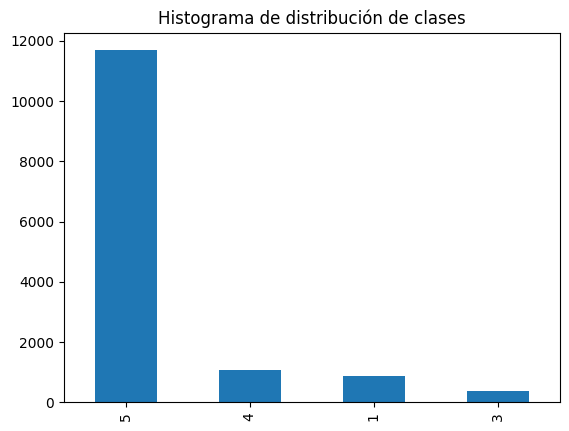

In [48]:
# Agrupa las categorías 1 y 2 y las asigna a categoría 1
df['Estrellas'] = df['Estrellas'].apply(lambda Y: 1 if Y in [1, 2] else int(Y))
df['Estrellas'].value_counts()

df['Estrellas'].value_counts().plot(kind='bar', title='Histograma de distribución de clases')
print(df['Estrellas'].value_counts() / len(df))




In [49]:
df['Estrellas'].dtype

dtype('int64')

In [50]:
Y, X = df['Estrellas'], df['Título']
X = X.apply(lemmatizar_y_limpiar)

le = LabelEncoder()
y = le.fit_transform(Y)
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)
print(type(X_train_text))

<class 'pandas.core.series.Series'>


In [51]:
vec = TfidfVectorizer(stop_words=stop_spanish, ngram_range=(1,1))
x_train = vec.fit_transform(X_train_text)
x_test = vec.transform(X_test_text)

CountVectorizer y Bernoulli

In [52]:
vec1 = CountVectorizer(stop_words=stop_spanish, binary=True, ngram_range=(1,3))
x_train1 = vec1.fit_transform(X_train_text)
x_test1 = vec1.transform(X_test_text)
bnb1 = BernoulliNB_sk()
bnb1.fit(x_train1, y_train)
print(f'Score para BN Bernoulli {bnb1.score(x_test1, y_test)}')

# Imprimir esparcidad del train y test
print(x_train1.nnz / (x_train1.shape[0] * x_train1.shape[1])*100)
print(x_test1.nnz / (x_test1.shape[0] * x_test1.shape[1])*100)
print(type(x_train1))

# Informe de clasificación
y_pred = bnb1.predict(x_test1)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Bernoulli 0.8342368045649072
0.0339335658367866
0.026146066810453793
<class 'scipy.sparse._csr.csr_matrix'>
              precision    recall  f1-score   support

           1       1.00      0.01      0.03       222
           3       0.00      0.00      0.00        93
           4       0.00      0.00      0.00       269
           5       0.83      1.00      0.91      2921

    accuracy                           0.83      3505
   macro avg       0.46      0.25      0.23      3505
weighted avg       0.76      0.83      0.76      3505

Reales     0     3   All
Predichos               
0          3   219   222
1          0    93    93
2          0   269   269
3          0  2921  2921
All        3  3502  3505


In [53]:
# Definir los pesos de clase
class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 0.17
}

# Calcular las probabilidades a priori a partir de los pesos de clase
class_priors = [class_weights[i] / sum(class_weights.values()) for i in range(len(class_weights))]

# Crear el clasificador Bernoulli Naive Bayes con pesos de clase
bnb2 = BernoulliNB_sk(class_prior=class_priors, fit_prior=False)

# Entrenar el modelo
bnb2.fit(x_train1, y_train)

# Evaluar el modelo en el conjunto de prueba
print(f'Score para BN Bernoulli con pesos {bnb2.score(x_test1, y_test)}')

# Informe de clasificación
y_pred = bnb2.predict(x_test1)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Bernoulli con pesos 0.83509272467903
              precision    recall  f1-score   support

           1       0.64      0.03      0.06       222
           3       0.00      0.00      0.00        93
           4       0.00      0.00      0.00       269
           5       0.84      1.00      0.91      2921

    accuracy                           0.84      3505
   macro avg       0.37      0.26      0.24      3505
weighted avg       0.74      0.84      0.76      3505

Reales      0  2     3   All
Predichos                   
0           7  1   214   222
1           2  0    91    93
2           1  0   268   269
3           1  0  2920  2921
All        11  1  3493  3505


In [54]:
# Sobremuestreo con SMOTE
# Aplica SMOTE al conjunto de entrenamiento (con auto, all y not majority da igual)
smote = SMOTE(sampling_strategy='not majority', random_state=1)
x_train_resampled_cv, y_train_resampled_cv = smote.fit_resample(x_train1, y_train)

# Entrenamiento del modelo en el conjunto de entrenamiento sobremuestreado
bnb1.fit(x_train_resampled_cv, y_train_resampled_cv)

# Evalúa el modelo en el conjunto de prueba original
print(f'Score para BN Bernoulli con oversampling SMOTE {bnb1.score(x_test1, y_test)}')

# Informe de clasificación
y_pred = bnb1.predict(x_test1)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Bernoulli con oversampling SMOTE 0.5209700427960057
              precision    recall  f1-score   support

           1       0.40      0.68      0.50       222
           3       0.07      0.25      0.11        93
           4       0.08      0.34      0.13       269
           5       0.92      0.53      0.68      2921

    accuracy                           0.52      3505
   macro avg       0.37      0.45      0.35      3505
weighted avg       0.80      0.52      0.61      3505

Reales       0    1     2     3   All
Predichos                            
0          150   36    10    26   222
1           36   23    21    13    93
2           43   33    91   102   269
3          149  248   962  1562  2921
All        378  340  1084  1703  3505


In [55]:
# Sobremuestreo con RandomOverSampler
# Aplica RandomOverSampler al conjunto de entrenamiento
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=1)
x_train_resampled2_cv, y_train_resampled2_cv = oversampler.fit_resample(x_train1, y_train)

# Entrenamiento del modelo en el conjunto de entrenamiento sobremuestreado
bnb1.fit(x_train_resampled2_cv, y_train_resampled2_cv)

# Evalúa el modelo en el conjunto de prueba original
print(f'Score para BN Bernoulli con oversampling RandomOverSampler {bnb1.score(x_test1, y_test)}')

# Informe de clasificación
y_pred = bnb1.predict(x_test1)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Bernoulli con oversampling RandomOverSampler 0.7349500713266762
              precision    recall  f1-score   support

           1       0.50      0.54      0.52       222
           3       0.14      0.23      0.17        93
           4       0.11      0.20      0.14       269
           5       0.91      0.82      0.86      2921

    accuracy                           0.73      3505
   macro avg       0.42      0.44      0.42      3505
weighted avg       0.80      0.73      0.77      3505

Reales       0    1    2     3   All
Predichos                           
0          119   41   19    43   222
1           29   21   20    23    93
2           26   23   54   166   269
3           62   64  413  2382  2921
All        236  149  506  2614  3505


Tf-IDF Multinomial

In [56]:
vec2 = TfidfVectorizer(stop_words=stop_spanish, ngram_range=(1,3))
x_train2 = vec2.fit_transform(X_train_text)
x_test2 = vec2.transform(X_test_text)
print('type x_train', type(x_train2))
mnb1 = MultinomialNB_sk()
mnb1.fit(x_train2, y_train)
print(f'Score para BN Multinomial {mnb1.score(x_test2, y_test)}')

# Informe de clasificación
y_pred = mnb1.predict(x_test2)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



type x_train <class 'scipy.sparse._csr.csr_matrix'>
Score para BN Multinomial 0.8359486447931527
              precision    recall  f1-score   support

           1       0.90      0.04      0.08       222
           3       0.00      0.00      0.00        93
           4       0.00      0.00      0.00       269
           5       0.84      1.00      0.91      2921

    accuracy                           0.84      3505
   macro avg       0.43      0.26      0.25      3505
weighted avg       0.75      0.84      0.76      3505

Reales      0     3   All
Predichos                
0           9   213   222
1           0    93    93
2           1   268   269
3           0  2921  2921
All        10  3495  3505


In [57]:
# Utilizando pesos de clases

# Crear el clasificador Multinomial Naive Bayes con pesos de clase
mnb2 = MultinomialNB_sk(class_prior=class_priors, fit_prior=False)

# Entrenar el modelo
mnb2.fit(x_train2, y_train)

# Evaluar el modelo en el conjunto de prueba
print(f'Score para BN Multinomial con pesos {mnb2.score(x_test2, y_test)}')

# Informe de clasificación
y_pred = mnb2.predict(x_test2)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Multinomial con pesos 0.6139800285306705
              precision    recall  f1-score   support

           1       0.38      0.76      0.51       222
           3       0.09      0.09      0.09        93
           4       0.10      0.38      0.16       269
           5       0.93      0.64      0.76      2921

    accuracy                           0.61      3505
   macro avg       0.38      0.47      0.38      3505
weighted avg       0.81      0.61      0.68      3505

Reales       0   1    2     3   All
Predichos                          
0          168  16   29     9   222
1           39   8   36    10    93
2           50   5  101   113   269
3          184  65  797  1875  2921
All        441  94  963  2007  3505


In [58]:
# Sobremuestreo con SMOTE

# Aplica SMOTE al conjunto de entrenamiento (con auto, all y not majority da igual)
smote = SMOTE(sampling_strategy='not majority', random_state=1)
x_train_resampled_tf, y_train_resampled_tf = smote.fit_resample(x_train2, y_train)

# Entrenamiento del modelo en el conjunto de entrenamiento sobremuestreado
mnb1.fit(x_train_resampled_tf, y_train_resampled_tf)

# Evalúa el modelo en el conjunto de prueba original
print(f'Score para BN Multinomial con SMOTE {mnb1.score(x_test2, y_test)}')

# Informe de clasificación
y_pred = mnb1.predict(x_test2)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Multinomial con SMOTE 0.6582025677603424
              precision    recall  f1-score   support

           1       0.43      0.61      0.50       222
           3       0.12      0.31      0.17        93
           4       0.11      0.30      0.16       269
           5       0.93      0.71      0.80      2921

    accuracy                           0.66      3505
   macro avg       0.40      0.48      0.41      3505
weighted avg       0.81      0.66      0.72      3505

Reales       0    1    2     3   All
Predichos                           
0          135   56    9    22   222
1           33   29   19    12    93
2           33   35   82   119   269
3          116  128  616  2061  2921
All        317  248  726  2214  3505


In [59]:
# Sobremuestreo con RandomOverSampler
# Aplica RandomOverSampler al conjunto de entrenamiento
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=1)
x_train_resampled2_tf, y_train_resampled2_tf = oversampler.fit_resample(x_train2, y_train)

# Entrenamiento del modelo en el conjunto de entrenamiento sobremuestreado
mnb1.fit(x_train_resampled2_tf, y_train_resampled2_tf)

# Evalúa el modelo en el conjunto de prueba original
print(f'Score para BN Multinomial con oversampling RandomOverSampler {mnb1.score(x_test2, y_test)}')

# Informe de clasificación
y_pred = mnb1.predict(x_test2)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Multinomial con oversampling RandomOverSampler 0.6830242510699002
              precision    recall  f1-score   support

           1       0.41      0.62      0.50       222
           3       0.13      0.30      0.18        93
           4       0.12      0.28      0.17       269
           5       0.93      0.74      0.82      2921

    accuracy                           0.68      3505
   macro avg       0.40      0.49      0.42      3505
weighted avg       0.81      0.68      0.73      3505

Reales       0    1    2     3   All
Predichos                           
0          138   52   11    21   222
1           36   28   17    12    93
2           33   33   76   127   269
3          128  108  533  2152  2921
All        335  221  637  2312  3505


###complement

In [60]:
vec3 = CountVectorizer(stop_words=stop_spanish, ngram_range=(1,3))
x_train3 = vec3.fit_transform(X_train_text)
x_test3 = vec3.transform(X_test_text)
cnb1 = ComplementNB_sk()
cnb1.fit(x_train3, y_train)
print(f'Score para BN Complement {cnb1.score(x_test3, y_test)}')

# Informe de clasificación
y_pred = cnb1.predict(x_test3)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Complement 0.8336661911554921
              precision    recall  f1-score   support

           1       0.48      0.69      0.56       222
           3       0.16      0.11      0.13        93
           4       0.16      0.04      0.07       269
           5       0.90      0.94      0.92      2921

    accuracy                           0.83      3505
   macro avg       0.43      0.45      0.42      3505
weighted avg       0.80      0.83      0.81      3505

Reales       0   1   2     3   All
Predichos                         
0          153  16   6    47   222
1           33  10  10    40    93
2           39   5  12   213   269
3           96  30  48  2747  2921
All        321  61  76  3047  3505


In [61]:
# Pesos de clase y probabilidades a priori a partir de los pesos de clase
class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 0.17
}

class_priors = [class_weights[i] / sum(class_weights.values()) for i in range(len(class_weights))]

# Crear el clasificador Complement Naive Bayes con pesos de clase
cnb2 = ComplementNB_sk(class_prior=class_priors, fit_prior=False)

# Entrenar el modelo
cnb2.fit(x_train3, y_train)

# Evaluar el modelo en el conjunto de prueba
print(f'Score para BN Complement con pesos de clase {cnb2.score(x_test3, y_test)}')

# Informe de clasificación
y_pred = cnb2.predict(x_test3)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Complement con pesos de clase 0.8336661911554921
              precision    recall  f1-score   support

           1       0.48      0.69      0.56       222
           3       0.16      0.11      0.13        93
           4       0.16      0.04      0.07       269
           5       0.90      0.94      0.92      2921

    accuracy                           0.83      3505
   macro avg       0.43      0.45      0.42      3505
weighted avg       0.80      0.83      0.81      3505

Reales       0   1   2     3   All
Predichos                         
0          153  16   6    47   222
1           33  10  10    40    93
2           39   5  12   213   269
3           96  30  48  2747  2921
All        321  61  76  3047  3505


In [62]:
# Aplica SMOTE al conjunto de entrenamiento (con auto, all y not majority da igual)
smote = SMOTE(sampling_strategy='not majority', random_state=1)
x_train_resampled_cv, y_train_resampled_cv = smote.fit_resample(x_train3, y_train)

# Entrenamiento del modelo en el conjunto de entrenamiento sobremuestreado
cnb1.fit(x_train_resampled_cv, y_train_resampled_cv)

# Evalúa el modelo en el conjunto de prueba original
print(f'Score para BN Complement SMOTE {cnb1.score(x_test3, y_test)}')

# Informe de clasificación
y_pred = cnb1.predict(x_test3)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Complement SMOTE 0.7126961483594865


              precision    recall  f1-score   support

           1       0.40      0.71      0.51       222
           3       0.20      0.18      0.19        93
           4       0.12      0.25      0.16       269
           5       0.92      0.77      0.84      2921

    accuracy                           0.71      3505
   macro avg       0.41      0.48      0.42      3505
weighted avg       0.80      0.71      0.75      3505

Reales       0   1    2     3   All
Predichos                          
0          158  17    6    41   222
1           36  17   19    21    93
2           44  12   66   147   269
3          160  38  466  2257  2921
All        398  84  557  2466  3505


In [63]:
# Entrenamiento del modelo en el conjunto de entrenamiento sobremuestreado
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=1)
x_train_resampled2_cv, y_train_resampled2_cv = oversampler.fit_resample(x_train3, y_train)


# Entrenamiento del modelo en el conjunto de entrenamiento sobremuestreado
cnb1.fit(x_train_resampled2_cv, y_train_resampled2_cv)

# Evalúa el modelo en el conjunto de prueba original
print(f'Score para BN Complement RandomOverSampler {cnb1.score(x_test3, y_test)}')

# Informe de clasificación
y_pred = cnb1.predict(x_test3)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Score para BN Complement RandomOverSampler 0.6861626248216833
              precision    recall  f1-score   support

           1       0.41      0.64      0.50       222
           3       0.11      0.25      0.15        93
           4       0.10      0.22      0.14       269
           5       0.92      0.75      0.82      2921

    accuracy                           0.69      3505
   macro avg       0.39      0.46      0.40      3505
weighted avg       0.80      0.69      0.73      3505

Reales       0    1    2     3   All
Predichos                           
0          143   41    8    30   222
1           35   23   18    17    93
2           38   27   58   146   269
3          129  115  496  2181  2921
All        345  206  580  2374  3505


Redes Neuronales

In [64]:
## Se utiliza early stopping para intentar evitar el sobreajuste. Se emplea RandomOverSampler

# Convertir matrices dispersas en matrices densas para el sobremuestreo
x_train = x_train.toarray()
x_test = x_test.toarray()

# Realiza el sobremuestreo solo en el conjunto de entrenamiento
oversampler = RandomOverSampler(sampling_strategy='not minority', random_state=1)
X_train_resampled, y_train_resampled = oversampler.fit_resample(x_train, y_train)

np.random.seed(1)
tf.random.set_seed(1)


# Define el modelo de la red neuronal
model = keras.Sequential([
    keras.layers.Input(shape=(X_train_resampled.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

# Compila el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrena el modelo con el conjunto de entrenamiento sobremuestreado y EarlyStopping
model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evalúa el modelo en el conjunto de prueba original
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Precisión en el conjunto de prueba. Redes Neuronales con RandomOverSampler: {test_acc}')

# Informe de clasificación
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)


Epoch 1/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6843 - loss: 0.7886 - val_accuracy: 0.4370 - val_loss: 0.9711
Epoch 2/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8531 - loss: 0.3815 - val_accuracy: 0.5719 - val_loss: 0.7617
Epoch 3/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8786 - loss: 0.3046 - val_accuracy: 0.6099 - val_loss: 0.6535
Epoch 4/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8993 - loss: 0.2554 - val_accuracy: 0.6539 - val_loss: 0.5792
Epoch 5/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9112 - loss: 0.2235 - val_accuracy: 0.6869 - val_loss: 0.5401
Epoch 6/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9190 - loss: 0.2045 - val_accuracy: 0.7010 - val_loss: 0.5214
Epoch 7/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9233 - loss: 0.1922 - val_accuracy: 0.7008 - val_loss: 0.5160
Epoch 8/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9265 - loss: 0.1843 - val_accu

In [65]:
# Realiza el sobremuestreo solo en el conjunto de entrenamiento
smote = SMOTE(sampling_strategy='not minority', random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

np.random.seed(1)
tf.random.set_seed(1)


# Define el modelo de la red neuronal
model = keras.Sequential([
    keras.layers.Input(shape=(X_train_resampled.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

# Compila el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrena el modelo con el conjunto de entrenamiento sobremuestreado y EarlyStopping
model.fit(X_train_resampled, y_train_resampled, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evalúa el modelo en el conjunto de prueba original
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Precisión en el conjunto de prueba. Redes Neuronales con SMOTE: {test_acc}')

# Informe de clasificación
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Epoch 1/200
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7037 - loss: 0.7770 - val_accuracy: 0.4006 - val_loss: 1.0459
Epoch 2/200
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8441 - loss: 0.3965 - val_accuracy: 0.5188 - val_loss: 0.8188
Epoch 3/200
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8759 - loss: 0.3056 - val_accuracy: 0.5988 - val_loss: 0.6804
Epoch 4/200
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8991 - loss: 0.2485 - val_accuracy: 0.6481 - val_loss: 0.6067
Epoch 5/200
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9106 - loss: 0.2160 - val_accuracy: 0.6699 - val_loss: 0.5625
Epoch 6/200
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9188 - loss: 0.1971 - val_accuracy: 0.6906 - val_loss: 0.5276
Epoch 7/200
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9230 - loss: 0.1851 - val_accuracy: 0.7098 - val_loss: 0.5006
Epoch 8/200
665/665 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9262 - loss: 0.1776 - val_accu

In [66]:
# Utilizando Early Stopping + pesos por clases
# Define el modelo de la red neuronal

np.random.seed(1)
tf.random.set_seed(1)

model = keras.Sequential([
    keras.layers.Input(shape=(x_train.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

# Compila el modelo con pesos de clase

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrena el modelo
model.fit(x_train, y_train, epochs=100, batch_size=32, sample_weight=np.array([class_weights[c] for c in y_train]), validation_split=0.2, callbacks=[early_stopping] )

# Evalúa el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Precisión en el conjunto de prueba. Redes Neuronales con Pesos : {test_acc}')

# Informe de clasificación
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Epoch 1/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7225 - loss: 0.3712 - val_accuracy: 0.7608 - val_loss: 0.3007
Epoch 2/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8185 - loss: 0.2659 - val_accuracy: 0.7194 - val_loss: 0.3084
Epoch 3/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8222 - loss: 0.2172 - val_accuracy: 0.7147 - val_loss: 0.3349
Epoch 4/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8422 - loss: 0.1771 - val_accuracy: 0.7166 - val_loss: 0.3632
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7690 - loss: 0.7202
Precisión en el conjunto de prueba. Redes Neuronales con Pesos : 0.7657632231712341
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           1       0.38      0.83      0.52       222
           3       0.00      0.00      0.00        93
           4       0.12      0.16      0.14       269
           5       0.92      0.84      0.88      2921

    accuracy

Regresión Logística

In [67]:
# Define el modelo de regresión logística
logreg = LogisticRegression(max_iter=200)

# Entrena el modelo
logreg.fit(x_train, y_train)

# Evalúa el modelo en el conjunto de prueba
test_acc = logreg.score(x_test, y_test)
print(f'Precisión en el conjunto de prueba. Reg Log: {test_acc}')

# Informe de clasificación
y_pred = logreg.predict(x_test)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Precisión en el conjunto de prueba. Reg Log: 0.8559201141226819
              precision    recall  f1-score   support

           1       0.67      0.39      0.49       222
           3       0.00      0.00      0.00        93
           4       0.10      0.00      0.01       269
           5       0.87      1.00      0.93      2921

    accuracy                           0.86      3505
   macro avg       0.41      0.35      0.36      3505
weighted avg       0.77      0.86      0.80      3505

Reales       0  1   2     3   All
Predichos                        
0           87  1   1   133   222
1           22  0   6    65    93
2           14  0   1   254   269
3            7  0   2  2912  2921
All        130  1  10  3364  3505


In [68]:
# Realiza el sobremuestreo solo en el conjunto de entrenamiento
oversampler = RandomOverSampler(sampling_strategy='not minority', random_state=1)
X_train_resampled, y_train_resampled = oversampler.fit_resample(x_train, y_train)

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train_resampled, y_train_resampled)

test_acc = logreg.score(x_test, y_test)
print(f'Precisión en el conjunto de prueba. Reg Log: {test_acc}')

# Informe de clasificación
y_pred = logreg.predict(x_test)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Precisión en el conjunto de prueba. Reg Log: 0.6770328102710413
              precision    recall  f1-score   support

           1       0.41      0.75      0.53       222
           3       0.00      0.00      0.00        93
           4       0.12      0.37      0.18       269
           5       0.93      0.72      0.81      2921

    accuracy                           0.68      3505
   macro avg       0.37      0.46      0.38      3505
weighted avg       0.81      0.68      0.72      3505

Reales       0  1    2     3   All
Predichos                         
0          167  1   26    28   222
1           50  0   31    12    93
2           45  0  100   124   269
3          143  0  672  2106  2921
All        405  1  829  2270  3505


In [69]:
# Utilizando pesos de clases
# Define el modelo de regresión logística
logreg2 = LogisticRegression(class_weight=class_weights, max_iter=200)

# Entrena el modelo
logreg2.fit(x_train, y_train)

# Evalúa el modelo en el conjunto de prueba
test_acc = logreg2.score(x_test, y_test)
print(f'Precisión en el conjunto de prueba. Reg Log con pesos de clases: {test_acc}')

# Informe de clasificación
y_pred = logreg2.predict(x_test)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Precisión en el conjunto de prueba. Reg Log con pesos de clases: 0.797432239657632
              precision    recall  f1-score   support

           1       0.49      0.73      0.59       222
           3       0.33      0.02      0.04        93
           4       0.14      0.16      0.15       269
           5       0.91      0.89      0.90      2921

    accuracy                           0.80      3505
   macro avg       0.47      0.45      0.42      3505
weighted avg       0.81      0.80      0.80      3505

Reales       0  1    2     3   All
Predichos                         
0          162  1   10    49   222
1           40  2   19    32    93
2           36  1   44   188   269
3           90  2  242  2587  2921
All        328  6  315  2856  3505


In [70]:
# Sobremuestreo con SMOTE
# Aplica SMOTE al conjunto de entrenamiento (con auto, all y not majority da igual)
smote = SMOTE(sampling_strategy='not majority', random_state=1)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Define el modelo de regresión logística
logreg = LogisticRegression(max_iter=300)

# Entrena el modelo en el conjunto de entrenamiento sobremuestreado
logreg.fit(x_train_resampled, y_train_resampled)

# Evalúa el modelo en el conjunto de prueba
test_acc = logreg.score(x_test, y_test)
print(f'Precisión en el conjunto de prueba. Reg Log con SMOTE: {test_acc}')

# Informe de clasificación
y_pred = logreg.predict(x_test)
etiquetas = ['1', '3', '4', '5']
print(classification_report(y_test, y_pred, target_names=etiquetas))

# Tabla de contingencia
tabla_cont = pd.crosstab(y_test, y_pred, rownames=['Predichos'], colnames=['Reales'], margins=True)
print(tabla_cont)



Precisión en el conjunto de prueba. Reg Log con SMOTE: 0.6239657631954351
              precision    recall  f1-score   support

           1       0.39      0.68      0.50       222
           3       0.08      0.19      0.11        93
           4       0.11      0.35      0.17       269
           5       0.94      0.66      0.77      2921

    accuracy                           0.62      3505
   macro avg       0.38      0.47      0.39      3505
weighted avg       0.82      0.62      0.69      3505

Reales       0    1    2     3   All
Predichos                           
0          152   35   19    16   222
1           38   18   26    11    93
2           40   30   95   104   269
3          155  149  695  1922  2921
All        385  232  835  2053  3505


###Nubes de Palabras
#####Se realizan nubes de palabras para visualizar las más frecuentes en cada categoría de estrellas.

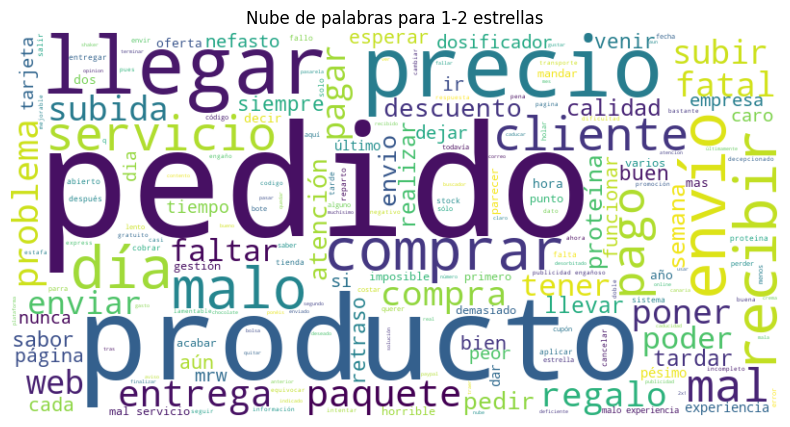

In [71]:
# Combina ambas listas de stopwords
custom_stopwords = {'ser', 'haber', 'hacer', 'vez', 'hsn'} #palabras que NO nos interesa visualizar en la nube de palabras
all_stopwords = set(stop_spanish).union(custom_stopwords)

# Crear una función para generar la nube de palabras
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=all_stopwords).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generar nubes de palabras para las categorías de 1 y 2 estrellas
titles_for_star = ' '.join(X[df['Estrellas'] == 1])
generate_wordcloud(titles_for_star, f'Nube de palabras para 1-2 estrellas')


In [72]:
# Obtener las palabras más frecuentes en la categoría 1 sin stopwords
text_category_1 = ' '.join(X[df['Estrellas'] == 1])
filtered_words = [word for word in text_category_1.split() if word.lower() not in all_stopwords]
word_counter = Counter(filtered_words)
top_words = word_counter.most_common(15)

# Crear una lista con las palabras y sus frecuencias
words = [word[0] for word in top_words]
frequencies = [word[1] for word in top_words]

# Crear un subplot interactivo con Plotly
fig = make_subplots(rows=1, cols=1, subplot_titles=["Las 15 palabras más frecuentes en la categoría 1-2 estrellas"])

# Crear el gráfico de barras interactivas
bar_chart = go.Bar(x=words, y=frequencies, marker_color='skyblue', name="Frecuencia")
fig.add_trace(bar_chart)

# Actualizar el diseño del gráfico
fig.update_layout(xaxis_title="Palabras",
                  yaxis_title="Frecuencia",
                  showlegend=True)

# Mostrar el gráfico interactivo
fig.show()

Se observa que los términos que aparecen con mayor frecuencia en la nube de palabras de la categoría más baja están relacionados con el envío (llegar, recibir, entrega, pedido, día, paquete). También aparece con frecuencia la palabra precio, lo que probablemente se deba al contexto inflacionario.

En este sentido, y dado que el servicio de transporte se encuentra tercerizado, se propone como posible estrategia de mejora el cambio de la empresa que brinda el servicio. Además de esta modificación, se ofrecerá a los clientes que han realizado reseñas negativas, un descuento del 50% en su siguiente compra.



### Valoración

**Si se considera:**
- Valor de compra promedio 25€ (valor a partir del cual se ofrece envío gratuito)
- Promedio de 4 compras anuales por cliente


*TP:* el modelo predice una baja calificación cuando efectivamente lo es. Si se retiene o recupera un cliente que da una mala reseña esto representaría 25€ x 4 – 12,5€ (valor del descuento) = 87,5€

*FP:* el modelo predice una calificación baja cuando no lo es. Si se ofrece un descuento a un cliente que no está disconforme, se estaría perdiendo 12,5€ (lo que se deja de ganar por ofrecer un descuento)

*FN:* el modelo predice que una calificación es buena cuando en realidad no lo es (falla en detectar las bajas calificaciones). En este caso no se realiza ninguna acción. Se establece un valor = 0.

*TN:* el modelo predice que una calificación es buena cuando esta lo es. En este caso no se realiza ninguna acción. Se establece un valor = 0.

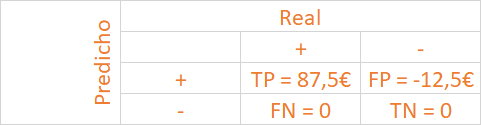

Tabla: Valoración de los distintos modelos

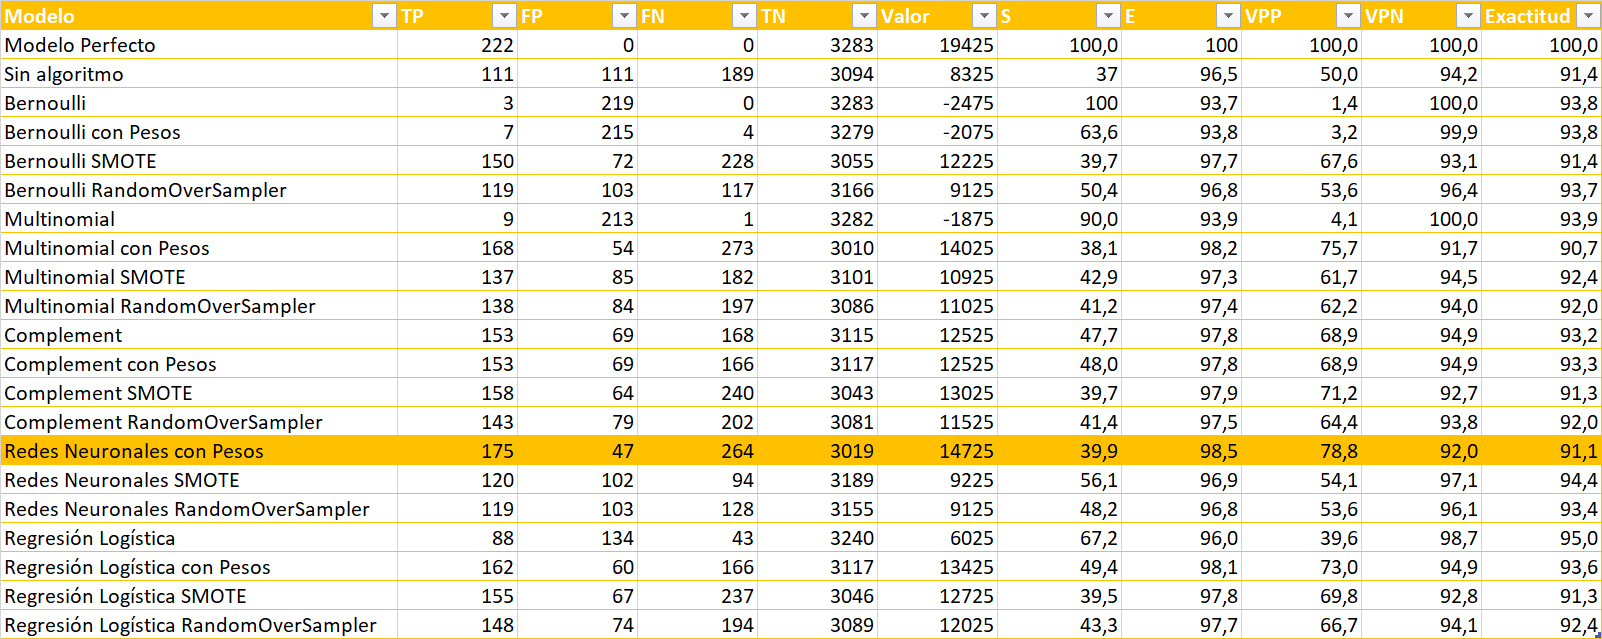


**Valor =87,5 x VP - 12,5 x FP - 0 x FN + 0 x VN**




# Consideraciones

Limitaciones del Modelo:
- Los todos los modelos presentan valores de accuracy globales aceptables, aunque esto se debe a la influencia de la categoría 5 estrellas.
- Cuando se observan las métricas para la categoría de interés (1-2 estrellas), estas no son buenas.
- Si bien se intentó balancear el dataset, la categoría 5 estrellas sigue siendo muy grande, lo cual influye la performance de los modelos. 
- Todos los modelos evaluados han mostrado una baja sensibilidad (recall) en la categoría 1 estrella., lo que significa que NO fueron muy propensos a detectarla. Sin embargo, al agrupar las categorías 1 y 2 estrellas, se puede observar una mejora en las métricas. 
 

Si se considera:
- Valor de compra promedio 25€ (valor a partir del cual se ofrece envío gratuito)
- Existen 886 reseñas con 1 y 2 estrellas en total, lo que representa un promedio de 230 por año (reseñas desde enero 2020 hasta octubre 2023). Se realizará la estimación considerando un que una reseña representa al usuario.
- 230 usuarios x 25€ x 4 pedidos anuales = 23.000€ anuales que podrían ganarse si el 100% de estos usuarios continuaran comprando (20.125 el primer año)
- Si la estrategia que incluye el descuento y la mejora del transporte, lograra un efecto positivo en al menos el 50%, se estarían recuperando 11.500€ anuales (10.062 el primer año)


La estimación del valor potencial se realiza considerando el valor promedio de compra, el número de reseñas anuales y la posible recuperación económica mediante estrategias de descuento y mejora en el transporte. La aplicación de la estrategia podría resultar en la recuperación de una cantidad significativa de ingresos anuales, especialmente si se logra un impacto positivo en al menos el 50% de los usuarios insatisfechos.


Uso del modelo propuesto: A pesar de las limitaciones métricas, el modelo propuesto puede desempeñar un papel valioso en el monitoreo de los motivos de insatisfacción de los clientes a través de las reseñas disponibles.
Además, puede ser una herramienta efectiva para evaluar el impacto potencial de diversas estrategias comerciales, permitiendo una asignación más eficiente de recursos y una toma de decisiones más informada.
Recomendaciones y oportunidades de mejora: Es crucial considerar futuras mejoras, como la expansión del conjunto de datos, la recopilación de información adicional sobre la experiencia del cliente y la exploración de técnicas avanzadas de procesamiento de lenguaje natural para mejorar la comprensión de las reseñas.
Se podría explorar la posibilidad de incorporar características adicionales, como el sentimiento expresado en las reseñas, para mejorar la capacidad del modelo para capturar matices emocionales.

Conclusiones: La elección del modelo de redes neuronales con pesos por clases se basa en la tabla de valorización que considera descuentos en compras futuras.  
A pesar de las limitaciones, el modelo propuesto presenta un valor práctico en términos de la toma de decisiones empresariales, especialmente cuando se considera el impacto económico de las estrategias implementadas. Es una herramienta valiosa para comprender y abordar las preocupaciones de los clientes, así como para evaluar el rendimiento de las iniciativas comerciales.

